# Simulating Back Propagating Action Potentials (BPAP) 

## Introduction

In this tutorial, we will walk you through simulating Back Propagating Action Potentials (BPAPs) using `bluecellulab`. BPAP is a phenomenon in which an action potential, typically originating in the soma of a neuron, propagates backwards into the dendritic tree. This is key for neural signaling and synaptic plasticity, forming the basis for learning and memory in biological organisms.

### Compiling the mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. With NEURON installed, simply run the following command for the compilation.

In [1]:
!nrnivmodl ../mechanisms

/home/tuncel/git-repos/BlueCelluLab/examples/3-bpap
Mod files: "../mechanisms/../mechanisms/CaDynamics_DC0.mod" "../mechanisms/../mechanisms/CaDynamics_E2.mod" "../mechanisms/../mechanisms/Ca_HVA2.mod" "../mechanisms/../mechanisms/Ca_HVA.mod" "../mechanisms/../mechanisms/Ca_LVAst.mod" "../mechanisms/../mechanisms/Ca.mod" "../mechanisms/../mechanisms/DetAMPANMDA.mod" "../mechanisms/../mechanisms/DetGABAAB.mod" "../mechanisms/../mechanisms/gap.mod" "../mechanisms/../mechanisms/GluSynapse.mod" "../mechanisms/../mechanisms/Ih.mod" "../mechanisms/../mechanisms/Im.mod" "../mechanisms/../mechanisms/KdShu2007.mod" "../mechanisms/../mechanisms/K_Pst.mod" "../mechanisms/../mechanisms/K_Tst.mod" "../mechanisms/../mechanisms/Nap_Et2.mod" "../mechanisms/../mechanisms/NaTa_t.mod" "../mechanisms/../mechanisms/NaTg.mod" "../mechanisms/../mechanisms/NaTs2_t.mod" "../mechanisms/../mechanisms/netstim_inhpoisson.mod" "../mechanisms/../mechanisms/ProbAMPANMDA_EMS.mod" "../mechanisms/../mechanisms/ProbGABAA

Let's dive into the code:

### Importing Required Libraries

We first import the necessary libraries and modules. Don't forget to install them if you don't have them already.

In [2]:
from pathlib import Path
from itertools import islice

import numpy as np
from matplotlib.pyplot import get_cmap
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from bluecellulab import Cell, neuron
from bluecellulab.simulation import Simulation
from bluecellulab.stimulus.circuit_stimulus_definitions import Hyperpolarizing
from bluecellulab.circuit.circuit_access import EmodelProperties


### Defining Helper Function

In [3]:
def get_peak_index(voltage, stim_start: int, stim_end: int) -> int:
    """Get the peak voltage from a trace."""
    return voltage[stim_start:stim_end].argmax() + stim_start

The `get_peak_index` function is a helper function that locates the index of the maximum value (peak) in the voltage array within a given interval, corresponding to the time of peak voltage.

### Creating the BPAP Class

In [4]:
class BPAP:

    def __init__(self, cell: Cell) -> None:
        self.cell = cell
        self.dt = 0.025
        self.stim_start = 1000
        self.stim_duration = 1

    @property
    def start_index(self) -> int:
        """Get the index of the start of the stimulus."""
        return int(self.stim_start / self.dt)

    @property
    def end_index(self) -> int:
        """Get the index of the end of the stimulus."""
        return int((self.stim_start + self.stim_duration) / self.dt)

    def select_dendritic_recordings(self, all_recordings : dict[str, float]) -> dict[str, float]:
        """Select dendritic recordings from all recordings."""
        res = {}
        for key, value in all_recordings.items():
            if "myelin" in key:
                continue
            elif "axon" in key:
                continue
            else:
                res[key] = value
        return res

    def run(self, duration: float, amplitude: float) -> None:
        """Apply depolarization and hyperpolarization at the same time."""
        sim = Simulation()
        sim.add_cell(self.cell)
        self.cell.add_allsections_voltagerecordings()
        self.cell.add_step(start_time=self.stim_start, stop_time=self.stim_start+self.stim_duration, level=amplitude)
        hyperpolarizing = Hyperpolarizing("single-cell", delay=self.stim_start, duration=self.stim_duration)
        self.cell.add_replay_hypamp(hyperpolarizing)
        sim.run(duration, dt=self.dt, cvode=False)

    def voltage_attenuation(self) -> dict[str, float]:
        """Return soma peak voltage across all sections."""
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma_key = [key for key in dendritic_recordings.keys() if key.endswith("soma[0]")][0]
        soma_voltage = dendritic_recordings[soma_key]
        soma_peak_index = get_peak_index(soma_voltage, self.start_index, self.end_index)
        res = {}
        for key, voltage in dendritic_recordings.items():
            peak_index_volt = voltage[soma_peak_index]
            res[key] = peak_index_volt
        return res

    def peak_delays(self) -> dict[str, float]:
        """Return the peak delays in each section."""
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma_key = [key for key in dendritic_recordings.keys() if key.endswith("soma[0]")][0]
        soma_voltage = dendritic_recordings[soma_key]
        soma_peak_index = get_peak_index(soma_voltage, self.start_index, self.end_index)
        res = {}
        for key, voltage in dendritic_recordings.items():
            peak_index = get_peak_index(voltage, self.start_index, self.end_index)
            index_delay = peak_index - soma_peak_index
            time_delay = index_delay * self.dt
            res[key] = time_delay
        return res

    def distances_to_soma(self) -> dict[str, float]:
        """Return the distance to the soma for each section."""
        res = {}
        all_recordings = self.cell.get_allsections_voltagerecordings()
        dendritic_recordings = self.select_dendritic_recordings(all_recordings)
        soma = self.cell.soma
        for key in dendritic_recordings.keys():
            section_name = key.rsplit(".")[-1].split("[")[0]  # e.g. "dend"
            section_idx = int(key.rsplit(".")[-1].split("[")[1].split("]")[0])  # e.g. 0
            attribute_value = getattr(self.cell.cell.getCell(), section_name)
            section = next(islice(attribute_value, section_idx, None))
            # section e.g. cADpyr_L2TPC_bluecellulab_x[0].dend[0]
            res[key] = neuron.h.distance(soma(0.5),section(0.5))
        return res


We define a class, `BPAP`, to encapsulate the functionality for simulating and analyzing BPAPs. The class constructor takes a `Cell` object from `bluecellulab` and initializes the time step (`dt`), stimulus start time (`stim_start`), and stimulus duration (`stim_duration`).

### Understanding Properties and Methods

Several methods are defined within the `BPAP` class to support the simulation and analysis of BPAPs:

* `start_index` and `end_index`: These properties calculate the indices corresponding to the start and end of the stimulus.
* `select_dendritic_recordings`: This method filters out the axon and myelin recordings from all section recordings to focus on the dendrites.
* `run`: This method sets up and runs the simulation. It first creates a `Simulation` object, adds the `Cell` to the simulation, applies a step current stimulus, and then applies a hyperpolarizing stimulus to the cell. Finally, it runs the simulation with the specified duration and time step.
* `voltage_attenuation`: This method calculates the peak voltage in all dendritic sections at the time of the soma peak.
* `peak_delays`: This method calculates the time delay in each dendritic section to reach its peak voltage after the soma.
* `distances_to_soma`: This method calculates the distance of each dendritic section to the soma.

These methods combined give us a comprehensive insight into the back-propagation of the action potential. We can then understand how changes in synaptic strength may occur, which are crucial to neural learning and memory formation.

### Running a Simulation

To run a simulation, create a `Cell` object, instantiate a `BPAP` object with the cell, and call the `run` method.

### Analyzing the Results

After running a simulation, we can call the `voltage_attenuation`, `peak_delays`, and `distances_to_soma` methods to analyze the results. Each of these methods provides a different aspect of BPAP: voltage distribution, time delays for action potentials, and the spatial layout of the dendritic tree.

This tutorial provides a good starting point for using the `bluecellulab` library to simulate and analyze BPAPs. Happy simulating!

## Loading the Neuron Model

Next, we load the neuron model that we'll be using for our simulation. The neuron model is specified through a morphology file and a hoc file. The hoc file contains the NEURON code defining the neuron's physiology, while the morphology file defines the neuron's shape and structure. In this tutorial, we will use a Pyramidal neuron model.

In [5]:
# Define the base directory
base_dir = Path("../1-singlecell/")

# Define the hoc and morphology files
hoc_file = base_dir / "hoc" / "cADpyr_L2TPC.hoc"
morph_file = base_dir / "morphology" / "rr110330_C3_idA.asc"

emodel_properties = EmodelProperties(threshold_current=0.03203125,
                                     holding_current=-0.11,
                                     AIS_scaler=1.11)
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

	1 


## Initializing the BPAP Simulation

Once the neuron model is loaded, we can set up the BPAP simulation.

In [6]:
bpap = BPAP(cell)

## Running the Simulation

With the BPAP simulation set up, we can now run it. We'll run the simulation for a duration of 1500 ms with a stimulus amplitude of 3.

In [7]:
bpap.run(duration=1500, amplitude=3)

## Analyzing the Results

Now that the simulation has run, we can analyze the results by calculating voltage attenuation, peak delays, and distances to soma.

In [8]:
voltage_attenuation = bpap.voltage_attenuation()
peak_delays = bpap.peak_delays()
distances_to_soma  = bpap.distances_to_soma()

## Plotting the Results

We will plot the voltage of different sections of the neuron over time to visualize the backpropagation of the action potential. We will also plot voltage attenuation and peak delays against the distance to soma to analyze the relationship between these factors.

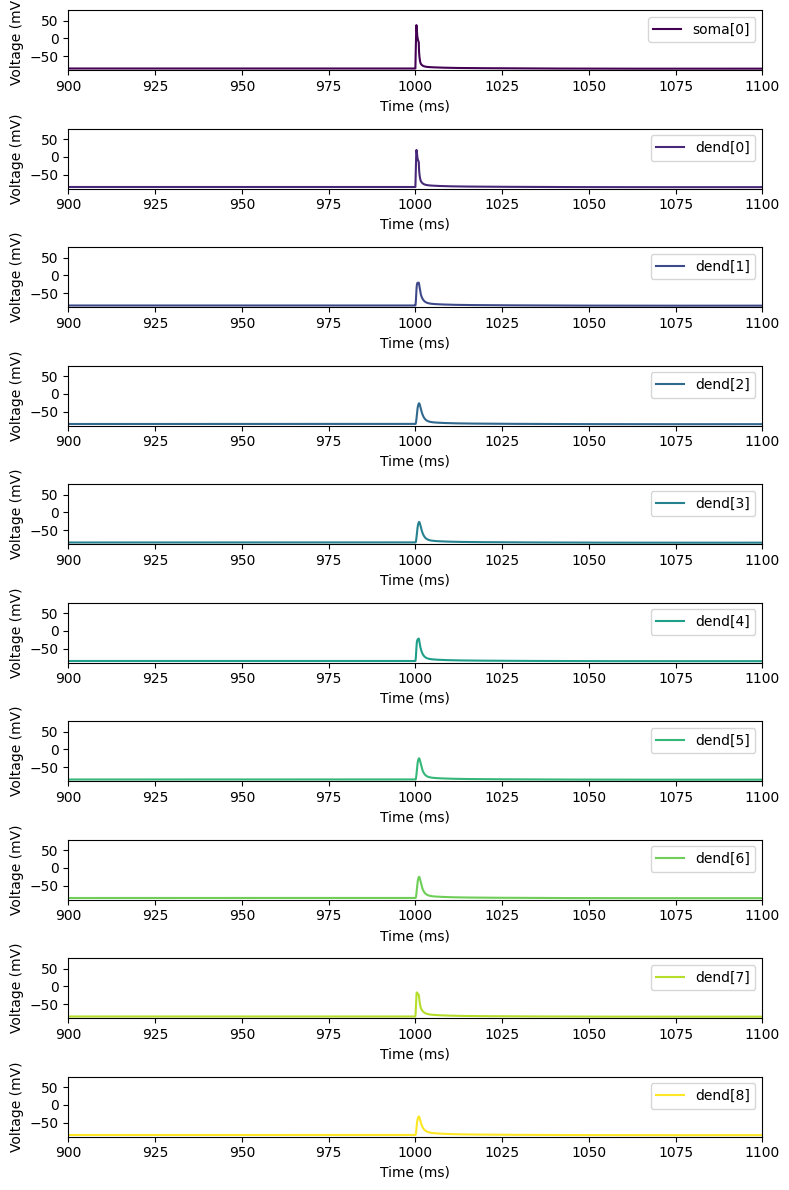

In [9]:
all_recordings = bpap.cell.get_allsections_voltagerecordings()
soma_key = [key for key in all_recordings.keys() if key.endswith("soma[0]")][0]

time = cell.get_time()
soma_voltage = all_recordings[soma_key]

# Define the figure size
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(8, 12))

subtree = list(all_recordings.keys())[:10]
# Define colormap
color_map = get_cmap('viridis', len(subtree))

# plot the voltage recordings from the subtree
for i, (ax, section) in enumerate(zip(axes, subtree)):
    voltage = all_recordings[section]
    ax.plot(time, voltage, label=section.split(".")[-1], color=color_map(i))
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.set_ylim(-90, 80)  # Set y-axis limits
    ax.set_xlim(900, 1100)  # Set x-axis limits

plt.tight_layout()  # This ensures that the plots don't overlap
plt.show()

### Plotting Voltage Peak Amplitude vs Distance to Soma

/tmp/ipykernel_31723/2640247676.py:6: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c


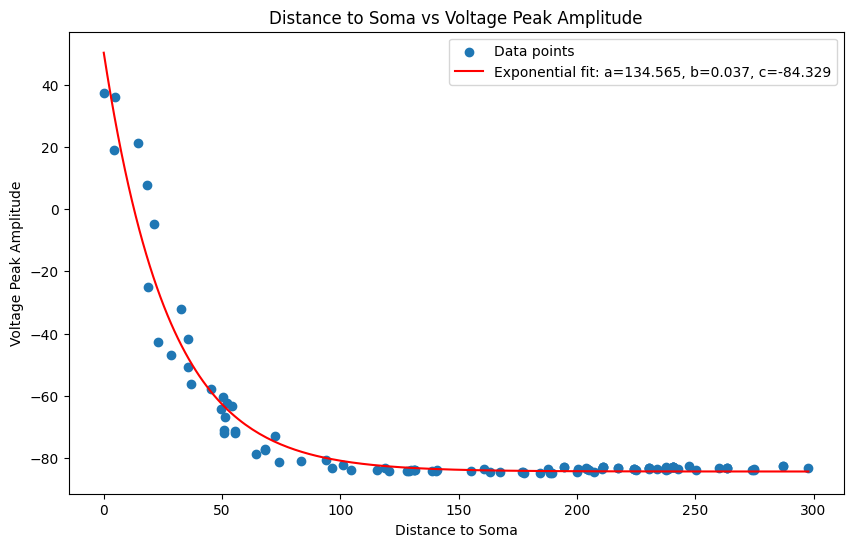

In [10]:
distances = list(distances_to_soma.values())
voltages = list(voltage_attenuation.values())

# The exponential that we wish to fit
def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

# Use curve_fit to find the best parameters
popt, pcov = curve_fit(exponential_decay, distances, voltages)

# Create an array of x values for plotting
x_vals = np.linspace(min(distances), max(distances), 200)

# Plot the original data and the fitted function
plt.figure(figsize=(10, 6))
plt.scatter(distances, voltages, label='Data points')
plt.plot(x_vals, exponential_decay(x_vals, *popt), color='red', label='Exponential fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.title('Distance to Soma vs Voltage Peak Amplitude')
plt.xlabel('Distance to Soma')
plt.ylabel('Voltage Peak Amplitude')
plt.legend()
plt.show()

### Plotting Peak Delays vs Distance to Soma

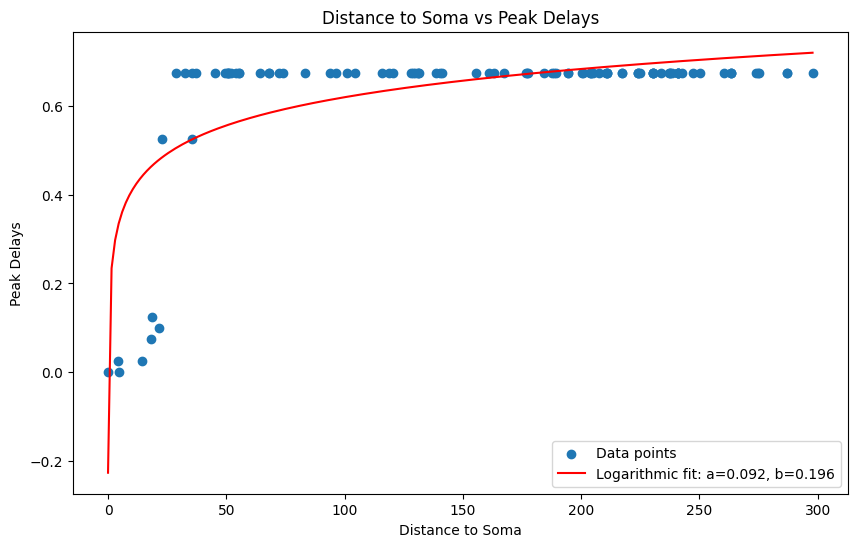

In [11]:
# Convert to lists for easier manipulation
distances = list(distances_to_soma.values())
delays = list(peak_delays.values())

def log_func(x, a, b):
    return a * np.log(x) + b

# Since log(0) is undefined, we add a small constant to distances
distances_shifted = np.array(distances) + 0.01 

popt, pcov = curve_fit(log_func, distances_shifted, delays)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(distances, delays, label='Data points')

# Plot the fitted function
x_vals = np.linspace(min(distances_shifted), max(distances_shifted), 200)
plt.plot(x_vals, log_func(x_vals, *popt), color='red', label='Logarithmic fit: a=%5.3f, b=%5.3f' % tuple(popt))


# Labels and title
plt.title('Distance to Soma vs Peak Delays')
plt.xlabel('Distance to Soma')
plt.ylabel('Peak Delays')

# Legend
plt.legend()

plt.show()

And that's it! We've simulated and analyzed back-propagating action potentials in a pyramidal neuron. We hope this tutorial serves as a helpful starting point for your own neuronal modeling studies!